## Testing notebook showing basic functionality

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
from calc_utils import kml_to_shp, load_shp, normalize_shps, shp_to_land, plot_land, observations_to_circles, expand_observations, \
                       daily_score_union, daily_attibution, monthly_attribution, cummulative_attribution, daily_video

In [ ]:
# transform plots kml to shp
kml_to_shp(source_directory='test_data/KML/', destination_directory='test_data/SHP/')

In [121]:
# loading shp files
shp = load_shp('test_data/SHP/')
# some preprocessing of shps
normalized_shapes = normalize_shps(shp)
plots = shp_to_land(normalized_shapes)
# creating html map
plot_land(plots, 'test_plots.html')
print('You can see the map at test_plots.html')
plots.head()

You can see the map at test_plots.html


,geometry
18,"POLYGON Z ((-76.79781 0.87076 0.00000, -76.793..."
3,"POLYGON Z ((-76.79010 0.88457 0.00000, -76.787..."
9,"POLYGON Z ((-76.75651 0.89384 0.00000, -76.754..."


In [122]:
# loading observations
records = pd.read_csv('test_data/observations.csv')
print('Number of test observations: ', len(records))
records.head()

Number of test observations:  48


,eco_id,eco_date,species_id,name_common,name_latin,radius,score,lat,long,iNaturalist
0,11369,2023-11-30,22,rec4OhXboLvO3936j,Panthera onca,11,1.0,0.87029,-76.79010,https://www.inaturalist.org/observations/19457...
1,11136,2023-11-18,592,recUOMlBGkJ0ngdp1,Minquartia guianensis,2,0.5,0.89400,-76.75440,NaN
2,10897,2023-11-09,28,reccyb69IWR64Etqs,Ampelocera albertiae,6,0.5,0.89115,-76.75542,NaN
3,10905,2023-11-09,28,reccyb69IWR64Etqs,Ampelocera albertiae,6,0.5,0.89280,-76.75530,NaN
4,10896,2023-11-09,28,reccyb69IWR64Etqs,Ampelocera albertiae,6,0.5,0.89102,-76.75514,NaN


In [123]:
# from observations to circles
# crs for observations is 4326 because it is lat/lon
# crs for circles is 6262 because it is in meters
records = observations_to_circles(records, default_crs=4326, buffer_crs=6262)
records.head()

,eco_id,eco_date,species_id,name_common,name_latin,radius,score,lat,long,iNaturalist,geometry
0,11369,2023-11-30,22,rec4OhXboLvO3936j,Panthera onca,11,1.0,0.87029,-76.79010,https://www.inaturalist.org/observations/19457...,"POLYGON ((-76.69131 0.87027, -76.69179 0.86052..."
1,11136,2023-11-18,592,recUOMlBGkJ0ngdp1,Minquartia guianensis,2,0.5,0.89400,-76.75440,NaN,"POLYGON ((-76.73644 0.89400, -76.73653 0.89222..."
2,10897,2023-11-09,28,reccyb69IWR64Etqs,Ampelocera albertiae,6,0.5,0.89115,-76.75542,NaN,"POLYGON ((-76.70154 0.89114, -76.70180 0.88582..."
3,10905,2023-11-09,28,reccyb69IWR64Etqs,Ampelocera albertiae,6,0.5,0.89280,-76.75530,NaN,"POLYGON ((-76.70142 0.89279, -76.70168 0.88747..."
4,10896,2023-11-09,28,reccyb69IWR64Etqs,Ampelocera albertiae,6,0.5,0.89102,-76.75514,NaN,"POLYGON ((-76.70126 0.89101, -76.70152 0.88569..."


In [124]:
# each observation is "expanded" to the 29 days before and 30 days after the observation date
obs_expanded = expand_observations(records)
obs_expanded.head()

,eco_id,eco_date,species_id,name_common,name_latin,radius,score,lat,long,iNaturalist,geometry,day,date
0,11369,2023-11-30,22,rec4OhXboLvO3936j,Panthera onca,11,1.0,0.87029,-76.7901,https://www.inaturalist.org/observations/19457...,"POLYGON ((-76.69131 0.87027, -76.69179 0.86052...",-29,2023-11-01
1,11369,2023-11-30,22,rec4OhXboLvO3936j,Panthera onca,11,1.0,0.87029,-76.7901,https://www.inaturalist.org/observations/19457...,"POLYGON ((-76.69131 0.87027, -76.69179 0.86052...",-28,2023-11-02
2,11369,2023-11-30,22,rec4OhXboLvO3936j,Panthera onca,11,1.0,0.87029,-76.7901,https://www.inaturalist.org/observations/19457...,"POLYGON ((-76.69131 0.87027, -76.69179 0.86052...",-27,2023-11-03
3,11369,2023-11-30,22,rec4OhXboLvO3936j,Panthera onca,11,1.0,0.87029,-76.7901,https://www.inaturalist.org/observations/19457...,"POLYGON ((-76.69131 0.87027, -76.69179 0.86052...",-26,2023-11-04
4,11369,2023-11-30,22,rec4OhXboLvO3936j,Panthera onca,11,1.0,0.87029,-76.7901,https://www.inaturalist.org/observations/19457...,"POLYGON ((-76.69131 0.87027, -76.69179 0.86052...",-25,2023-11-05


In [125]:
# the expanded observations are unioned to create a daily geometry for each score
# this process the venn_decomposition function, which decomposes a list of scored polygons into 
# a venn-like diagram, assigning the highest score to each section and merging the equal-score sections
daily_score = daily_score_union(obs_expanded)
daily_score.head()

,date,level_1,score,geometry
0,2018-12-08,0,1.0,"POLYGON ((-76.68943 0.86735, -76.68991 0.85761..."
1,2018-12-09,0,1.0,"POLYGON ((-76.68943 0.86735, -76.68991 0.85761..."
2,2018-12-10,0,1.0,"POLYGON ((-76.68943 0.86735, -76.68991 0.85761..."
3,2018-12-11,0,1.0,"POLYGON ((-76.68943 0.86735, -76.68991 0.85761..."
4,2018-12-12,0,1.0,"POLYGON ((-76.68943 0.86735, -76.68991 0.85761..."


Polygons for date:  2023-07-01
Displayed in separate plots for each score


,date,level_1,score,geometry
527,2023-07-01,0,0.5,"POLYGON ((-76.76310 0.81966, -76.76788 0.81739..."
528,2023-07-01,1,1.0,"POLYGON ((-76.81415 0.91518, -76.81415 0.91518..."


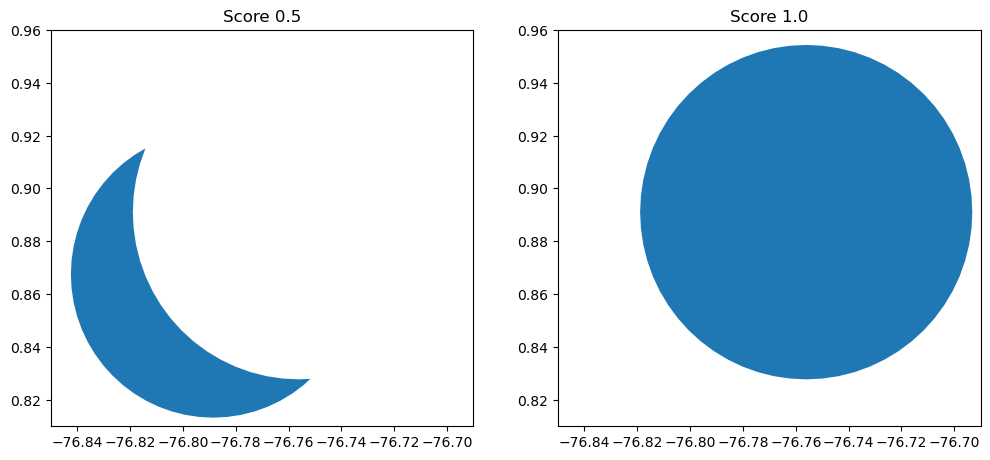

In [126]:
# just to visualize these geometries, we can pick a date and plot both scores
date = '2023-07-01'
print('Polygons for date: ', date)  
print('Displayed in separate plots for each score')
fig, ax = plt.subplots(1,2, figsize=(12,6))
daily_score.query(f'date == "{date}" and score == 0.5').plot(ax=ax[0])
daily_score.query(f'date == "{date}" and score ==  1').plot(ax=ax[1])
ax[0].set_xlim([-76.85, -76.69])
ax[0].set_ylim([0.81, 0.96])
ax[1].set_xlim([-76.85, -76.69])
ax[1].set_ylim([0.81, 0.96])
ax[0].set_title('Score 0.5')
ax[1].set_title('Score 1.0')
daily_score.query(f'date == "{date}"')

In [127]:
# now we can calculate the daily attribution for each plot_id-score-date combination
# the area_score is the area of the intersection of the score polygon and the plot polygon multiplied by the score
attribution = daily_attibution(daily_score, plots, obs_expanded, crs=6262)
attribution.head()

,plot_id,score,total_area,area_intersect,area_score,eco_id
date,,,,,,
2023-12-30,18,1.0,142.034201,142.034201,142.034201,[11369]
2023-12-30,3,1.0,64.834050,64.834050,64.834050,[11369]
2023-12-30,9,1.0,10.096988,10.096988,10.096988,[11369]
2023-12-29,18,1.0,142.034201,142.034201,142.034201,[11369]
2023-12-29,3,1.0,64.834050,64.834050,64.834050,[11369]


In [128]:
# now we can compute the monthly attibution
# the monthly attribution is the sum of the area_score for each plot_id-month combination divided by 60
# calc_index is the plot_id-month combination
attr_month = monthly_attribution(attribution)
attr_month.head()

,calc_index,calc_date,plot_id,total_area,credits,eco_id_list,eco_id
70,18-December-2023,2023-12-31,18,142.034201,71.017101,[11369],11369
71,3-December-2023,2023-12-31,3,64.834050,32.417025,[11369],11369
72,9-December-2023,2023-12-31,9,10.096988,5.048494,[11369],11369
67,18-November-2023,2023-11-30,18,142.034201,71.017101,"[10380, 11369]","10380, 11369"
68,3-November-2023,2023-11-30,3,64.834050,32.417025,"[10380, 11369]","10380, 11369"


In [129]:
# now we can compute the cummulative attributions
attr_cumm = cummulative_attribution(attr_month, cutdays = 30, start_date=None)
attr_cumm.head()


,plot_id,first_date,last_date,total_area,credits,eco_id_list,eco_id
0,3,2018-12-31,2023-11-30,64.834050,481.933107,"[53, 80, 87, 414, 415, 426, 1099, 1104, 1253, ...","53, 80, 87, 414, 415, 426, 1099, 1104, 1253, 1..."
1,9,2018-12-31,2023-11-30,10.096988,66.387697,"[53, 87, 1099, 1104, 1229, 1230, 1231, 1253, 1...","53, 87, 1099, 1104, 1229, 1230, 1231, 1253, 12..."
2,18,2018-12-31,2023-11-30,142.034201,1055.787562,"[53, 80, 87, 414, 415, 426, 1099, 1104, 1253, ...","53, 80, 87, 414, 415, 426, 1099, 1104, 1253, 1..."


In [ ]:
# finally for visualization we can create a video called raindrops.mp4
daily_video(daily_score, plots, first_date=None)